In [1]:
#------- general imports -------
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import glob
from functools import reduce

#------- multiprocessing ------
import tensorflow as tf
print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))
from numba import jit

#------- ML imports -------
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import mean_squared_error, mean_absolute_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.metrics import MeanAbsoluteError
from tensorflow.keras.initializers import Constant
from sklearn.metrics import r2_score

#------- plotting settings -------
import seaborn as sns
sns.set()
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
sns.set_context('paper')

cw = 8.325/2.54
tw = 17/2.54
l15 = 15/2.54
l12 = 12/2.54

from matplotlib.ticker import ScalarFormatter
from matplotlib import rcParams
rcParams['text.usetex'] = True
rcParams['text.latex.preamble'] = r'\usepackage{sansmathfonts}'
rcParams.update({
    "font.size": 8,       
    "axes.labelsize": 8,
    "xtick.labelsize": 8,
    "ytick.labelsize": 8,
    'axes.titlesize':9,
    'legend.fontsize': 8,
})
def saveplot(plotname):
    filename = f"../latex/images/{plotname}.pdf"
    plt.savefig(filename, bbox_inches='tight', pad_inches=0)
    plt.show()

2.20.0
[]


# 1. Preprocessing

## 1.1 Loading data

Even if we focus on Pont station only, we create flexible dictionaries that could potentially include data from other stations.

In [2]:
paths = glob.glob('../data/cf*/pont*.csv')
stations_raw_dict = {}

for i, path in enumerate(paths):
    station_name = path.split('\\')[-1].replace('.csv', '')
    df = pd.read_csv(path, 
                     sep=';',
                     decimal=',',
                     skiprows=9,
                     encoding='latin1')
    key = station_name
    stations_raw_dict[key] = df

stations_raw_dict

{'pont-irradiation':                      Data fine: 2025-12-02 23:59:59
 2025-11-02 00:00:00                             0.0
 2025-11-02 01:00:00                             0.0
 2025-11-02 02:00:00                             0.0
 2025-11-02 03:00:00                             0.0
 2025-11-02 04:00:00                             0.0
 ...                                             ...
 2025-12-02 07:00:00                             1.7
 2025-12-02 08:00:00                            70.7
 2025-12-02 09:00:00                           567.8
 2025-12-02 10:00:00                           605.2
 2025-12-02 11:00:00                             NaN
 
 [732 rows x 1 columns],
 'pont-precipitation':                      Data fine: 2025-12-02 23:59:59
 2025-11-02 00:00:00                             0.0
 2025-11-02 01:00:00                             0.0
 2025-11-02 02:00:00                             0.0
 2025-11-02 03:00:00                             0.2
 2025-11-02 04:00:00          

In [3]:
station_names = list(set([k.split('-')[0] for k in stations_raw_dict.keys()]))

stations_dict = {}

for station in station_names:
    # grouping dfs by station
    df_list = [df.rename(columns={df.columns[0]: k.split('-')[1]})  # rename column to variable
               for k, df in stations_raw_dict.items() if k.startswith(station)]
    
    merged_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), df_list)
    
    merged_df.index = pd.to_datetime(merged_df.index)
    merged_df = merged_df.sort_index()
    
    stations_dict[station] = merged_df

for station, df in stations_dict.items():
    print(f"{station}: {df.shape}")
    display(df.head())

pont: (816, 6)


,irradiation,precipitation,rhumidity,snowdepth,temperature,windspeed
2025-11-02 00:00:00,0.0,0.0,87.2,NaN,2.6,1.9
2025-11-02 01:00:00,0.0,0.0,88.0,NaN,2.7,1.3
2025-11-02 02:00:00,0.0,0.0,87.8,NaN,3.0,0.6
2025-11-02 03:00:00,0.0,0.2,89.3,NaN,3.1,0.4
2025-11-02 04:00:00,0.0,0.2,93.8,NaN,3.1,0.4


In [4]:
stations_dict['pont']

,irradiation,precipitation,rhumidity,snowdepth,temperature,windspeed
2025-11-02 00:00:00,0.0,0.0,87.2,NaN,2.6,1.9
2025-11-02 01:00:00,0.0,0.0,88.0,NaN,2.7,1.3
2025-11-02 02:00:00,0.0,0.0,87.8,NaN,3.0,0.6
2025-11-02 03:00:00,0.0,0.2,89.3,NaN,3.1,0.4
2025-11-02 04:00:00,0.0,0.2,93.8,NaN,3.1,0.4
...,...,...,...,...,...,...
2025-12-05 19:00:00,NaN,NaN,NaN,NaN,NaN,1.9
2025-12-05 20:00:00,NaN,NaN,NaN,NaN,NaN,2.0
2025-12-05 21:00:00,NaN,NaN,NaN,NaN,NaN,2.0
2025-12-05 22:00:00,NaN,NaN,NaN,NaN,NaN,1.4


## 1.2 Loading target data

In [5]:
paths = glob.glob('../data/cf*/target/pont*.csv')
stations_rawtarget_dict = {}

for i, path in enumerate(paths):
    station_name = path.split('\\')[-1].replace('.csv', '').replace('_target', '')
    df = pd.read_csv(path, 
                     sep=';',
                     decimal=',',
                     skiprows=9,
                     encoding='latin1')
    key = station_name
    stations_rawtarget_dict[key] = df

stations_rawtarget_dict

{'pont-irradiation':                      Data fine: 2025-12-05 23:59:59
 2025-12-02 00:00:00                             0.0
 2025-12-02 01:00:00                             0.0
 2025-12-02 02:00:00                             0.0
 2025-12-02 03:00:00                             0.0
 2025-12-02 04:00:00                             0.0
 ...                                             ...
 2025-12-05 11:00:00                           334.2
 2025-12-05 12:00:00                            55.0
 2025-12-05 13:00:00                             3.5
 2025-12-05 14:00:00                             0.0
 2025-12-05 15:00:00                             NaN
 
 [88 rows x 1 columns],
 'pont-precipitation':                      Data fine: 2025-12-05 23:59:59
 2025-12-02 00:00:00                             0.0
 2025-12-02 01:00:00                             0.0
 2025-12-02 02:00:00                             0.0
 2025-12-02 03:00:00                             0.0
 2025-12-02 04:00:00           

In [6]:
stations_target_dict = {}

for station in station_names:
    # grouping dfs by station
    df_list = [df.rename(columns={df.columns[0]: k.split('-')[1]})  # rename column to variable
               for k, df in stations_rawtarget_dict.items() if k.startswith(station)]
    
    merged_df = reduce(lambda left, right: pd.merge(left, right, left_index=True, right_index=True, how='outer'), df_list)
    
    merged_df.index = pd.to_datetime(merged_df.index)
    merged_df = merged_df.sort_index()
    
    stations_target_dict[station] = merged_df

for station, df in stations_target_dict.items():
    print(f"{station}: {df.shape}")
    display(df)

pont: (88, 5)


,irradiation,precipitation,rhumidity,snowdepth,temperature
2025-12-02 00:00:00,0.0,0.0,87.3,18.8,-7.6
2025-12-02 01:00:00,0.0,0.0,87.5,15.8,-7.3
2025-12-02 02:00:00,0.0,0.0,86.2,15.8,-7.8
2025-12-02 03:00:00,0.0,0.0,86.0,15.5,-7.8
2025-12-02 04:00:00,0.0,0.0,83.0,14.5,-7.8
...,...,...,...,...,...
2025-12-05 11:00:00,334.2,0.0,51.0,23.2,-0.1
2025-12-05 12:00:00,55.0,0.0,58.7,23.5,-2.3
2025-12-05 13:00:00,3.5,0.0,63.2,23.7,-3.6
2025-12-05 14:00:00,0.0,0.0,59.0,24.0,-3.4


After some days, I downloaded the data that will be used as "true value" to compare with our RNN forecast.
I then merged all the dfs.
Better constraints: add wind veocity (important for snow depth...)

In [7]:
stations_tot = {}

for station in stations_dict.keys():
    df_pred = stations_dict[station].copy()
    df_targ = stations_target_dict[station].copy()

    # joining on aligned timestamps
    df = pd.concat([df_pred, df_targ], axis=0)
    df = df.groupby(df.index).mean()

    df_filled = df.interpolate(method='time')

    df_filled = df_filled.ffill().bfill()

    # sort for safety   (ChatGPT hint)
    df = df.sort_index()

    stations_tot[station] = df

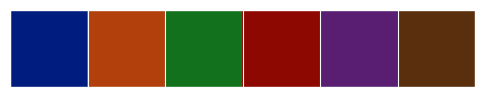

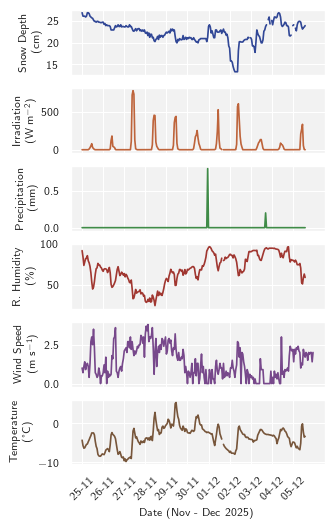

In [8]:
# plot some data
sorted_cols = ['snowdepth', 'irradiation', 'precipitation', 'rhumidity', 'windspeed', 'temperature']
stations_tot['pont'] = stations_tot['pont'].reindex(columns=sorted_cols)
pont_notscaled = stations_tot['pont']
df = pont_notscaled.loc['2025-11-25 00:00:00':]
p = len(df.columns)

palette = sns.color_palette("dark", 6)

sns.palplot(palette)

labels = ["Snow Depth\n(cm)",
          "Irradiation\n(W m$^{-2}$)",
          "Precipitation\n(mm)",
          "R. Humidity\n(\%)",
          "Wind Speed\n(m s$^{-1}$)",
          "Temperature\n(°C)"
          ]

fig, axes = plt.subplots(p, 1, figsize=(cw, l15), sharex=True)

for i, col in enumerate(df.columns):
    ax = axes.flatten()[i]
    ax.plot(df.index, df[col], 
            label=col,
            c=palette[i],
            alpha=0.8
            )
    ax.set_ylabel(labels[i])

xtick_labels = df.index.strftime('%d-%m')  
axes[5].set_xticks(df.index[::24])  # every 24 hours
axes[5].set_xticklabels(xtick_labels[::24], rotation=45)
axes[5].set_xlabel('Date (Nov - Dec 2025)')
saveplot('timeseries')

<Axes: >

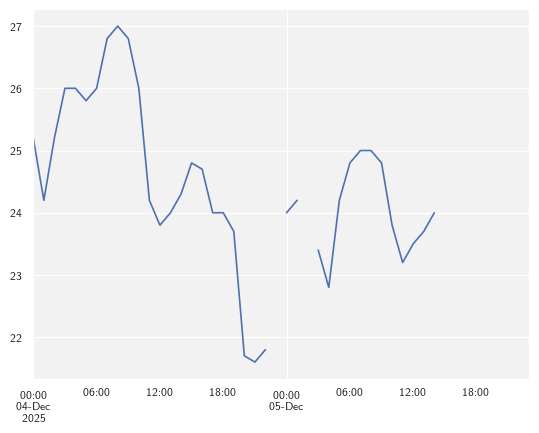

In [9]:
pont_notscaled['snowdepth'][-48:].plot()

## 1.3 Scaling

In [10]:
scaled_stations = {}
scalers = {}

for station, df in stations_tot.items():
    # drop columns that are fully NaN
    df_clean = df.dropna(axis=1, how="all")

    # if ALL columns were dropped → skip
    if df_clean.shape[1] == 0:
        print(f"Skipping station {station}: no valid columns left after dropna.")
        continue

    # if any NaNs remain → fill or drop rows, choose one:
    if df_clean.isna().sum().sum() > 0:
        # option A: forward/backward fill
        df_clean = df_clean.ffill().bfill()

        # option B: drop rows (safer but loses time steps)
        # df_clean = df_clean.dropna()

    # after filling/dropping, ensure final validity
    if df_clean.isna().sum().sum() > 0:
        print(f"Warning: NaNs still remain in {station}, skipping.")
        continue

    # scale
    scaler = StandardScaler()
    df_scaled = pd.DataFrame(
        scaler.fit_transform(df_clean),
        index=df_clean.index,
        columns=df_clean.columns
    )

    scaled_stations[station] = df_scaled
    scalers[station] = scaler

In [11]:
pont_df = scaled_stations['pont']
pont_df.isna().sum()

snowdepth        0
irradiation      0
precipitation    0
rhumidity        0
windspeed        0
temperature      0
dtype: int64

In [12]:
pont_df = pont_df[:-8]
pont_df

,snowdepth,irradiation,precipitation,rhumidity,windspeed,temperature
2025-11-02 00:00:00,-0.794622,-0.435242,-0.100197,1.218546,0.763538,0.953256
2025-11-02 01:00:00,-0.794622,-0.435242,-0.100197,1.258881,0.067266,0.976917
2025-11-02 02:00:00,-0.794622,-0.435242,-0.100197,1.248797,-0.745050,1.047898
2025-11-02 03:00:00,-0.794622,-0.435242,1.084740,1.324425,-0.977141,1.071558
2025-11-02 04:00:00,-0.794622,-0.435242,1.084740,1.551308,-0.977141,1.071558
...,...,...,...,...,...,...
2025-12-05 11:00:00,1.437691,2.135747,-0.100197,-0.606599,-0.048779,0.314427
2025-12-05 12:00:00,1.472571,-0.012129,-0.100197,-0.218378,1.111674,-0.206100
2025-12-05 13:00:00,1.495825,-0.408316,-0.100197,0.008505,0.763538,-0.513684
2025-12-05 14:00:00,1.530704,-0.435242,-0.100197,-0.203252,0.531447,-0.466364


# 2. Features selection
This study focuses on snow cover. We want to know what are the parameters to account for when predicting snow depth. Then we use Ridge and Lasso for feature selection. In this first part of the analysis, we split into train and test set as with any normal input with shape `(n_samples, n_features)`.

Note: we use `train_test_split` only in this part of the analysis. For forecasting, this will not be valid anymore.

## 2.1 Train-test split

In [61]:
sorted_cols

['snowdepth',
 'irradiation',
 'precipitation',
 'rhumidity',
 'windspeed',
 'temperature']

In [62]:
# we are forecasting 4 days ahead: these 4 days represents our test set, then.
start_train = '2025-11-02 00:00:00'
end_train = '2025-12-01 23:00:00'
start_test = '2025-12-02 00:00:00'
end_test = '2025-12-05 23:00:00'

# compute forecast window / whole set ratio
test_size = pont_df.loc[start_test:end_test].shape[0] / pont_df.loc[start_train:end_test].shape[0]
print(f"Forecast window = {test_size:.2%} of whole set")

# we select only features != snowdepth. Of course snowdepth is the best feature to predict snowdetph,
# but including it would be cheating and also would prevent us from seeing the effect of other features, since we are selecting 
# features in the next step. 
# We then exclude the first column.

X = pont_df.loc[start_train:end_test, sorted_cols[1:]]
y = pont_df.loc[start_train:end_test, 'snowdepth']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle=False)

Forecast window = 10.89% of whole set


In [63]:
from sklearn.utils import resample

def feature_selection(
        X, y,
        model_type="lasso",      # "lasso" or "ridge"
        alpha=1.0,
        n_boot=200,
        threshold_factor=0.05           # keep features with |coef| ≥ threshold * max|coef|
    ):
    """ Performs bootsrap to estimate feature coefficients using Ridge or Lasso regression; selects features to keep.
    ______________
    Parameters
        :: X : DataFrame | ndarray
            Training features (scaled).
        :: y : Series | ndarray
            Training target.
        :: model_type : str
            'ridge' or 'lasso'
        :: alpha : float
            Regularization strength.
        :: n_boot : int
            Number of bootstrap samples.
        :: threshold_factor : float
            Relative magnitude threshold for feature selection.
    ______________
    Returns:
        :: result : pd.DataFrame
            DataFrame with coefficients, std errors, CIs, and keep flag.
    """
    
    # linear model
    if model_type.lower() == "lasso":
        model = Lasso(alpha=alpha)
    elif model_type.lower() == "ridge":
        model = Ridge(alpha=alpha)
    else:
        raise ValueError("model_type must be 'lasso' or 'ridge'")

    model.fit(X, y)
    base_coefs = np.array(model.coef_)
    features = X.columns

    # bootstrap
    boot_coefs = np.zeros((n_boot, len(features)))

    for i in range(n_boot):
        Xb, yb = resample(X, y)
        m = Lasso(alpha=alpha) if model_type == "lasso" else Ridge(alpha=alpha)
        m.fit(Xb, yb)
        boot_coefs[i] = m.coef_

    # standard error of coefficients
    se = boot_coefs.std(axis=0)

    # 95% bootstrap percentile CI
    ci_low = np.percentile(boot_coefs, 2.5, axis=0)
    ci_high = np.percentile(boot_coefs, 97.5, axis=0)

    # feature selection by relative magnitude
    max_coef = np.max(np.abs(base_coefs))
    threshold = threshold_factor * max_coef 
    keep = np.abs(base_coefs) >= threshold

    result = pd.DataFrame({
        "coef" : base_coefs,
        "std_error" : se,
        "ci_2.5%" : ci_low,
        "ci_97.5%" : ci_high,
        "keep" : keep
    }, index=features)

    return boot_coefs, result, threshold

In [64]:
coefs, result, threshold = feature_selection(
    X_train, y_train,
    model_type="ridge",
    alpha=0.1,
    n_boot=200,
    threshold_factor=0.06
)

print(result)

                   coef  std_error   ci_2.5%  ci_97.5%  keep
irradiation    0.153323   0.030186  0.096179  0.205680  True
precipitation  0.033363   0.030208 -0.035902  0.062521  True
rhumidity      0.128191   0.031533  0.060283  0.195266  True
windspeed      0.180133   0.033895  0.116982  0.248730  True
temperature   -0.463970   0.030969 -0.529386 -0.404785  True


## 2.2 Tuning parameters

In [65]:
alphas = [1e-4, 1e-3, 1e-2, 1e-1, 1]
coefs_lasso_dict = {}
coefs_ridge_dict = {}
thresholds = []

for alpha in alphas:
    coefs_lasso, result_lasso, threshold_lasso = feature_selection(
        X_train, y_train,
        model_type="lasso",
        alpha=alpha,
        n_boot=200,
        threshold_factor=0.01
    )

    coefs_ridge, result_ridge, threshold_ridge = feature_selection(
        X_train, y_train,
        model_type="ridge",
        alpha=alpha,
        n_boot=200,
        threshold_factor=0.01
    )

    thresholds.append((threshold_lasso, threshold_ridge))
    coefs_lasso_dict[alpha] = coefs_lasso
    coefs_ridge_dict[alpha] = coefs_ridge

In [66]:
# ChatGPT helped in creating the following df in order to plot coefficients distributions
features = X_train.columns.tolist()  # or your list of feature names
rows = []

for alpha in alphas:
    coefs_lasso = np.array(coefs_lasso_dict[alpha], dtype=float)
    coefs_ridge = np.array(coefs_ridge_dict[alpha], dtype=float)
    
    # if 1D array
    if coefs_lasso.ndim == 1:
        for i, feature in enumerate(features):
            rows.append({'feature': feature, 'alpha': alpha, 'method': 'Lasso', 'coef': np.abs(coefs_lasso[i])})
            rows.append({'feature': feature, 'alpha': alpha, 'method': 'Ridge', 'coef': np.abs(coefs_ridge[i])})
    elif coefs_lasso.ndim == 2:
        n_boot = coefs_lasso.shape[0]
        for i, feature in enumerate(features):
            for b in range(n_boot):
                rows.append({'feature': feature, 'alpha': alpha, 'method': 'Lasso', 'coef': np.abs(coefs_lasso[b, i])})
                rows.append({'feature': feature, 'alpha': alpha, 'method': 'Ridge', 'coef': np.abs(coefs_ridge[b, i])})

df = pd.DataFrame(rows)
print(df.head())

       feature   alpha method      coef
0  irradiation  0.0001  Lasso  0.161945
1  irradiation  0.0001  Ridge  0.169427
2  irradiation  0.0001  Lasso  0.191931
3  irradiation  0.0001  Ridge  0.192114
4  irradiation  0.0001  Lasso  0.132249


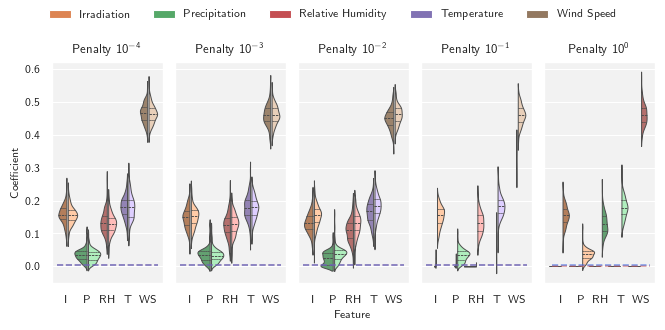

In [67]:
# plotting this was quite tricky. ChatGPT and ClaudeAI helped *a lot*.

features = df['feature'].unique()
labels = ['Irradiation', 'Precipitation', 'Relative Humidity', 'Temperature', 'Wind Speed']

# log alpha labels
alpha_logs = [np.log10(alpha) for alpha in alphas]
alphas_sn = [f"10$^{{{a:.0f}}}$" for a in alpha_logs]

palette_pastel = sns.color_palette('pastel',n_colors=len(features)+1)[1:]
palette_deep = sns.color_palette('deep',n_colors=len(features)+1)[1:]

# Create palette by METHOD only (Lasso, Ridge)
# But we'll handle the feature-specific colors manually
from matplotlib.colors import to_rgb, to_hex
# Plot
fig, axes = plt.subplots(1, len(alphas), figsize=(tw, cw), sharey=True)
for i, alpha in enumerate(alphas):
    ax = axes[i]
    df_alpha = df[df['alpha'] == alpha]
    
    # Plot with hue='method' for proper splitting
    sns.violinplot(
        ax=ax,
        data=df_alpha,
        x='feature',
        y='coef',
        hue='method',  # Only 2 levels: Lasso, Ridge
        linewidth=0.7,
        split=True,
        inner="quart",
        legend=False,
        fill=True,
        gap=0.1,
        width=1.35,
        dodge=0.001
    )
    
    # Get collections IMMEDIATELY after plotting, before they disappear
    collections = list(ax.collections)
    
    # Manually recolor each violin pair
    # Count non-empty collections and map them to features
    non_empty_idx = 0
    for j, (feature, base_color) in enumerate(zip(features, palette_pastel)):
        rgb = to_rgb(base_color)
        darker = tuple(c * 0.7 for c in rgb)
        lighter = tuple(c * 0.7 + 0.3 for c in rgb)
        
        # Expected positions for this feature
        left_idx = j * 2
        right_idx = j * 2 + 1
        
        # Check if left violin exists (non-empty paths)
        if left_idx < len(collections) and len(collections[left_idx].get_paths()) > 0:
            collections[left_idx].set_facecolor(darker)
        
        # Check if right violin exists (non-empty paths)
        if right_idx < len(collections) and len(collections[right_idx].get_paths()) > 0:
            collections[right_idx].set_facecolor(lighter)
    
    ax.set_ylabel("Coefficient" if i == 0 else "")
    ax.set_title(rf"Penalty {alphas_sn[i]}")
    ax.set_xlabel("Feature" if i == len(alphas)//2 else "")
    xticks = ['I', 'P', 'RH', 'T', 'WS']
    ax.set_xticks(range(len(features)))
    ax.set_xticklabels(xticks)

    ax.hlines(y=thresholds[i][0], xmin=-0.5, xmax=len(features)-0.5, 
              colors='indianred', alpha=0.6, linestyles='dashed', label='Lasso Threshold' if i==0 else "")
    ax.hlines(y=thresholds[i][1], xmin=-0.5, xmax=len(features)-0.5, 
              colors='royalblue', alpha=0.6, linestyles='dashed', label='Ridge Threshold' if i==0 else "")

# Create custom legend
from matplotlib.patches import Patch
legend_elements = []
for i, (feature, label) in enumerate(zip(features, labels)):
    legend_elements.append(Patch(facecolor=palette_deep[i], label=label))
fig.legend(handles=legend_elements, loc='upper center', ncol=len(features), frameon=False)
plt.tight_layout(rect=[0, 0, 1, 0.92])
saveplot("violins_coefs_ridge-lasso")


In [68]:
def stability_mse(X, y, model_type='lasso', alphas=None, n_boot=200):
    """
    Fits Ridge or Lasso models across a range of alphas, computing sample-specific MSE and bootstrap sign-stability.
    ______________
    Parameters
        :: X : DataFrame | ndarray
            Training features (scaled).
        :: y : Series | ndarray
            Training target.
        :: model_type : str
            'ridge' or 'lasso'.
        :: alphas : list | ndarray
            Sequence of alpha values to evaluate. If None, uses logspace(-4, 0, 15).
        :: n_boot : int
            Number of bootstrap samples used to estimate sign stability.
    ______________
    Returns
        :: results : pd.DataFrame
            Table with columns:
                - 'alpha' : tested regularization strengths
                - 'mse' : sample-specific mean squared error
                - 'n_nonzero' : count of non-zero coefficients (Lasso only)
        :: stability : pd.DataFrame
            DataFrame indexed by alpha with one column per feature.
            Each entry is the fraction of bootstrap models whose coefficient sign
            matches the sign of the model performed on the full dataset at the same alpha.
    """
    if alphas is None:
        alphas = np.logspace(-4, 0, 4)

    if model_type == 'lasso':
        Model = lambda a: Lasso(alpha=a, max_iter=10000)
    elif model_type == 'ridge':
        Model = lambda a: Ridge(alpha=a)
    else:
        raise ValueError("model_type must be 'lasso' or 'ridge'.")

    X_arr = np.asarray(X)
    y_arr = np.asarray(y).ravel()

    results = []
    stability = {}

    for a in alphas:
        # fitting the model for the full dataset
        model = Model(a)
        model.fit(X_arr, y_arr)
        mse = mean_squared_error(y_arr, model.predict(X_arr))
        coefs = model.coef_

        # bootstrap model fitting 
        signs = []
        for _ in range(n_boot):
            idx = np.random.choice(len(y_arr), len(y_arr), replace=True)
            Xb, yb = X_arr[idx], y_arr[idx]
            mb = Model(a)
            mb.fit(Xb, yb)
            signs.append(np.sign(mb.coef_))
        
        # compute sign stability
        signs = np.vstack(signs)
        stability_a = (np.mean(signs == np.sign(coefs), axis=0))  # fraction of consistent sign
        stability[a] = stability_a

        results.append({
            "alpha": a,
            "mse": mse,
            "n_nonzero": np.sum(np.abs(coefs) > 1e-6)
        })

    return (
        pd.DataFrame(results),
        pd.DataFrame(stability, index=X.columns).T   # rows = alpha, cols = features
    )

In [69]:
result_lasso, stability_lasso = stability_mse(X_train, y_train, alphas=[1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1], model_type='lasso')
result_ridge, stability_ridge = stability_mse(X_train, y_train, alphas=[1e-4, 5e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1, 5e-1, 1], model_type='ridge')

In [70]:
stability_lasso['mean'] = stability_lasso.mean(axis=1)
result_lasso

,alpha,mse,n_nonzero
0,0.0001,0.615070,5
1,0.0005,0.615072,5
2,0.0010,0.615078,5
3,0.0050,0.615272,5
4,0.0100,0.615877,5
5,0.0500,0.635259,5
6,0.1000,0.659862,2
7,0.5000,0.852860,0
8,1.0000,0.852860,0


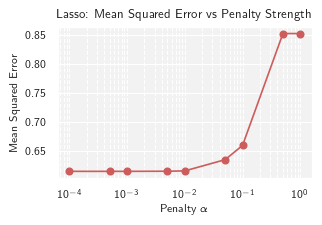

In [71]:
plt.figure(figsize=(cw, 5/2.54))
plt.title("Lasso: Mean Squared Error vs Penalty Strength")
plt.plot(result_lasso['alpha'], 
         result_lasso['mse'], 
         marker='o',
         color='indianred')
plt.xscale('log')
plt.xlabel(r'Penalty $\alpha$')
plt.ylabel('Mean Squared Error')

# Enable grid on x-axis (log scale)
plt.grid(True, which='both', axis='x', linestyle='--', alpha=1)
saveplot("mse_vs_alpha_lasso")

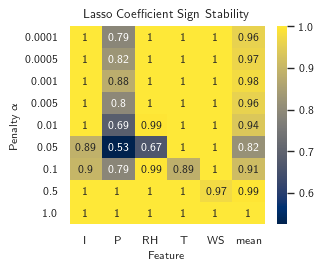

In [72]:
plt.figure(figsize=(cw, 7/2.54))
sns.heatmap(stability_lasso, 
            annot=True, 
            cmap='cividis',
            )
plt.xlabel('Feature')
plt.ylabel(r'Penalty $\alpha$')
plt.xticks(plt.gca().get_xticks(), ['I', 'P', 'RH', 'T', 'WS', 'mean'], rotation=0)
plt.title("Lasso Coefficient Sign Stability")
plt.tight_layout()
saveplot("heatmap_stability_lasso")

In [73]:
coefs, result, threshold = feature_selection(
    X_train, y_train,
    model_type="lasso",
    alpha=0.1,
    n_boot=400,
    threshold_factor=0.01
)

result

,coef,std_error,ci_2.5%,ci_97.5%,keep
irradiation,0.000000,0.005890,0.000000,0.026030,False
precipitation,0.000000,0.007000,0.000000,0.027967,False
rhumidity,0.000000,0.001097,0.000000,0.000000,False
windspeed,0.041677,0.030169,0.000000,0.111695,True
temperature,-0.332193,0.026639,-0.386878,-0.284433,True


# 3. LSTM forecasting

## 3.1 Chronological split

We now split the dataset in two parts: one with the measures we use to forecast, the other with the forecast window.
https://machinelearningmastery.com/how-to-develop-lstm-models-for-time-series-forecasting/

## 3.2 Sequencing

In [38]:
def create_sequence(time_series: np.ndarray | list | pd.DataFrame,
                    sequence_length: int,
                    forecast_horizon: int,
                    feature_cols: list = None,
                    target_col: int=None
                    ):
    """Creates sequences from a time series.
    ______________
    Params:
        :: time_series = full dataset containing past dayes measures and dayes to forecast. Daily or hourly step.
        :: sequence_length = length of each sequence 
        :: forecast_horizon = amount of forecasted time
        :: target_col = variable to be sequenced, if input is pd.DataFrame
    ______________
    Returns:
        :: X = sequenced array of shape used for training/testing (number of samples, sequence length) 
        :: Y = sequence of measures to be forecsted ("true" value)
    """
    # handling input type
    if isinstance(time_series, list):
        data = np.array(time_series)

    elif isinstance(time_series, pd.DataFrame):
        if target_col is None:
            raise ValueError("Specify target_col when passing a DataFrame.")
        if target_col not in time_series.columns:
            raise ValueError(f"'{target_col}' not found in DataFrame.")
        
        X_data = time_series[feature_cols].values
        Y_data = time_series[target_col].values.reshape(-1, 1)

        # stack features and target; 
        # last column is the target, which simplifies slicing later
        data = np.hstack([X_data, Y_data])

    else:
        data = np.array(time_series)


    # ensuring 2D
    if data.ndim == 1:
        data = data.reshape(-1, 1)

    n = len(data)

    X = []
    Y = []

    # last column = target
    for i in range(n - sequence_length - forecast_horizon):
        # input: full feature set for past sequence_length timesteps
        X.append(data[i : i + sequence_length, :-1])

        # output: future target only (not full vector)
        Y.append(data[i + sequence_length : i + sequence_length + forecast_horizon, -1])

    X = np.array(X)
    Y = np.array(Y)

    print(f"X shape = {X.shape}")
    print(f"Y shape = {Y.shape}")

    return X, Y

#### Temperature forecasting

In [39]:
target_cols = ['temperature', 'snowdepth', 'snowdepth']
feature_cols_list = [sorted_cols, sorted_cols, ['temperature', 'windspeed']]

In [40]:
feature_cols_list

[['snowdepth',
  'irradiation',
  'precipitation',
  'rhumidity',
  'windspeed',
  'temperature'],
 ['snowdepth',
  'irradiation',
  'precipitation',
  'rhumidity',
  'windspeed',
  'temperature'],
 ['temperature', 'windspeed']]

In [41]:
history_rows = 48       # input sequence length
horizon = 24            # forecast length
split_time = pd.Timestamp('2025-12-02 00:00:00')

train_sets = []
test_sets = []

for target_col, feature_cols in zip(target_cols, feature_cols_list):
    print(f"Preparing data for target: {target_col} with features: {feature_cols}")
    df_train = pont_df.loc[:split_time]
    df_test_input = pont_df.loc[
        split_time - pd.Timedelta(hours=history_rows):
    ]
    print(df_test_input)

    X_train, y_train = create_sequence(
        df_train,
        sequence_length=history_rows,
        forecast_horizon=horizon,
        feature_cols=feature_cols,
        target_col=target_col
    )

    X_test, y_test = create_sequence(
        df_test_input,
        sequence_length=history_rows,
        forecast_horizon=horizon,
        feature_cols=feature_cols,
        target_col=target_col
    )

    train_sets.append((X_train, y_train))
    test_sets.append((X_test, y_test))

    timesteps = X_train.shape[1]
    n_features = X_train.shape[2]

Preparing data for target: temperature with features: ['snowdepth', 'irradiation', 'precipitation', 'rhumidity', 'windspeed', 'temperature']
                     snowdepth  irradiation  precipitation  rhumidity  \
2025-11-30 00:00:00   1.205159    -0.435242      -0.100197   0.300932   
2025-11-30 01:00:00   1.181906    -0.435242      -0.100197   0.260597   
2025-11-30 02:00:00   1.216785    -0.435242      -0.100197   0.311015   
2025-11-30 03:00:00   1.205159    -0.435242      -0.100197   0.366476   
2025-11-30 04:00:00   1.205159    -0.435242      -0.100197   0.386643   
...                        ...          ...            ...        ...   
2025-12-05 11:00:00   1.437691     2.135747      -0.100197  -0.606599   
2025-12-05 12:00:00   1.472571    -0.012129      -0.100197  -0.218378   
2025-12-05 13:00:00   1.495825    -0.408316      -0.100197   0.008505   
2025-12-05 14:00:00   1.530704    -0.435242      -0.100197  -0.203252   
2025-12-05 15:00:00   1.530704    -0.435242      -0.1001

Testing `temperature` (with all features) and `snowdepth` (with all features + selected features) forecasting. 

In [43]:
results = {}

for target_col, feature_cols, (X_train, y_train), (X_test, y_test) in zip(
        target_cols, feature_cols_list, train_sets, test_sets):

    print(f"\nTraining LSTM for target: {target_col}")
    print(f"Features: {feature_cols}")

    n_features = X_train.shape[2]

    model = Sequential([
        LSTM(32, input_shape=(history_rows, n_features)),
        Dense(horizon)
    ])

    model.compile(
        optimizer='adam',
        loss='mse'
    )

    model.fit(
        X_train, y_train,
        epochs=75,
        batch_size=8,
        verbose=1
    )

    # --- last input window ---
    last_window = pont_df[feature_cols].iloc[-history_rows:].values
    last_window = last_window.reshape(1, history_rows, n_features)

    # --- forecast ---
    forecast_scaled = model.predict(last_window)

    # --- inverse scaling ---
    y_train_raw = df_clean[target_col].loc[:split_time].values
    target_scaler = StandardScaler()
    target_scaler.fit(y_train_raw.reshape(-1, 1))

    forecast_rescaled = target_scaler.inverse_transform(forecast_scaled)
    true_rescaled = target_scaler.inverse_transform(
        y_test[0].reshape(-1, 1)
    ).flatten()

    forecast_rescaled = forecast_rescaled.flatten()

    # --- metrics ---
    mse = mean_squared_error(true_rescaled, forecast_rescaled)
    r2 = r2_score(true_rescaled, forecast_rescaled)

    print(f"MSE = {mse:.4f}")
    print(f"R²  = {r2:.4f}")

    # --- store results ---
    results[target_col, tuple(feature_cols)] = {
        "forecast": forecast_rescaled,
        "true": true_rescaled,
        "mse": mse,
        "r2": r2
    }




Training LSTM for target: temperature
Features: ['snowdepth', 'irradiation', 'precipitation', 'rhumidity', 'windspeed', 'temperature']


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 10ms/step - loss: 0.6556
Epoch 2/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3475
Epoch 3/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.3256
Epoch 4/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2977
Epoch 5/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.2551
Epoch 6/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.2225
Epoch 7/75
66/82 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2075

KeyboardInterrupt: 

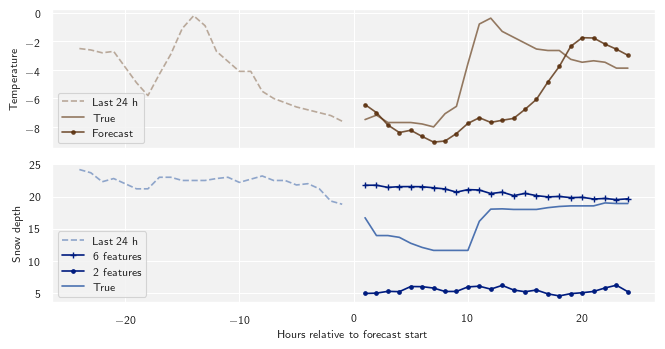

In [85]:
fig, axes = plt.subplots(2, 1, figsize=(tw, 9/2.54), sharex=True)

# time axes
t_context = np.arange(-24, 0)
t_forecast = np.arange(1, horizon + 1)

snow_color = sns.color_palette(n_colors=6)[0]
temp_color = sns.color_palette(n_colors=6)[5]

snow_forecast_color = sns.color_palette('dark', n_colors=6)[0]
temp_forecast_color = sns.color_palette('dark', n_colors=6)[5]

# =========================
# temperature
# =========================
key_temp = [k for k in results if k[0] == "temperature"][0]

# last 24 h before forecast
temp_context = df_clean["temperature"].loc[:split_time].values[-24:]

axes[0].plot(t_context, temp_context, 
                c=temp_color,  label="Last 24 h",
                alpha=0.6, linestyle='dashed')
axes[0].plot(t_forecast, results[key_temp]["true"], label="True",
             color=temp_color)
axes[0].plot(t_forecast, results[key_temp]["forecast"], marker=".", label="Forecast",
             color=temp_forecast_color, alpha=0.8)

axes[0].set_ylabel("Temperature")
axes[0].legend(loc='lower left')

# =========================
# snow depth
# =========================
snow_keys = [k for k in results if k[0] == "snowdepth"]

snow_context = df_clean["snowdepth"].loc[:split_time].values[-24:]

axes[1].plot(t_context, snow_context, linestyle='dashed', alpha=0.6, color=snow_color, label="Last 24 h")
markers = ['+', '.']
for i, key in enumerate(snow_keys):
    label = f"{len(key[1])} features"
    axes[1].plot(
        t_forecast,
        results[key]["forecast"],
        marker=markers[i],
        color=snow_forecast_color,
        label=label
    )

axes[1].plot(
    t_forecast,
    results[snow_keys[0]]["true"],
    color=snow_color,
    label="True"
)

axes[1].set_xlabel("Hours relative to forecast start")
axes[1].set_ylabel("Snow depth")
axes[1].legend(loc='lower left')

plt.tight_layout()
plt.show()


Test for:
- different model complexities
- different activation functions


In [ ]:
y_train

array([[-0.79462185, -0.79462185, -0.79462185, ..., -0.79462185,
        -0.79462185, -0.79462185],
       [-0.79462185, -0.79462185, -0.79462185, ..., -0.79462185,
        -0.79462185, -0.79462185],
       [-0.79462185, -0.79462185, -0.79462185, ..., -0.79462185,
        -0.79462185, -0.79462185],
       ...,
       [ 1.21678541,  1.20515878,  1.20515878, ...,  1.55395773,
         1.55395773,  1.69347731],
       [ 1.20515878,  1.20515878,  1.20515878, ...,  1.55395773,
         1.69347731,  1.7632371 ],
       [ 1.20515878,  1.20515878,  1.15865225, ...,  1.69347731,
         1.7632371 ,  1.57721099]])

In [ ]:
activations = ['relu', 'tanh', 'sigmoid', 'linear']
epochs_range = [25, 50, 75, 100, 125, 150]

# store results
mse_results = {}

for target_col, feature_cols, (X_train, y_train), (X_test, y_test) in zip(
        target_cols, feature_cols_list, train_sets, test_sets):

    print(f"\n=== Target: {target_col} | Features: {feature_cols} ===")

    n_features = X_train.shape[2]
    mse_matrix = np.zeros((len(activations), len(epochs_range)))

    # fit target scaler once per experiment
    y_train_raw = df_clean[target_col].loc[:split_time].values
    target_scaler = StandardScaler()
    target_scaler.fit(y_train_raw.reshape(-1, 1))

    for i, activation in enumerate(activations):
        for j, epochs in enumerate(epochs_range):

            print(f"Activation: {activation}, Epochs: {epochs}")

            model = Sequential([
                LSTM(
                    32,
                    activation=activation,
                    input_shape=(timesteps, n_features)
                ),
                Dense(horizon)
            ])

            model.compile(optimizer='adam', loss='mse')
            model.fit(
                X_train, y_train,
                epochs=epochs,
                batch_size=8,
                verbose=0
            )

            # Predict on full test set
            y_pred_scaled = model.predict(X_test, verbose=0)

            # Inverse scaling
            y_pred_rescaled = target_scaler.inverse_transform(
                y_pred_scaled.reshape(-1, 1)
            ).reshape(y_pred_scaled.shape)

            y_test_rescaled = target_scaler.inverse_transform(
                y_test.reshape(-1, 1)
            ).reshape(y_test.shape)

            mse = mean_squared_error(
                y_test_rescaled.flatten(),
                y_pred_rescaled.flatten()
            )

            mse_matrix[i, j] = mse
            print(f"MSE: {mse:.4f}")

    # Save matrix
    mse_results[target_col] = {
        "features": feature_cols,
        "mse_matrix": mse_matrix
    }


=== Target: temperature | Features: ['snowdepth', 'irradiation', 'precipitation', 'rhumidity', 'windspeed', 'temperature'] ===
Activation: relu, Epochs: 25


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 9.8722
Activation: relu, Epochs: 50


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 6.9161
Activation: relu, Epochs: 75


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 3.8119
Activation: relu, Epochs: 100


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 6.3132
Activation: relu, Epochs: 125


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 11.5913
Activation: relu, Epochs: 150


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 8.7413
Activation: tanh, Epochs: 25


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 10.7305
Activation: tanh, Epochs: 50


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 12.9045
Activation: tanh, Epochs: 75


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 5.0891
Activation: tanh, Epochs: 100


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 8.3092
Activation: tanh, Epochs: 125


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 6.7214
Activation: tanh, Epochs: 150


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 9.5259
Activation: sigmoid, Epochs: 25


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 12.7667
Activation: sigmoid, Epochs: 50


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 14.0379
Activation: sigmoid, Epochs: 75


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 11.7731
Activation: sigmoid, Epochs: 100


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 7.1221
Activation: sigmoid, Epochs: 125


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 6.6870
Activation: sigmoid, Epochs: 150


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 3.4139
Activation: linear, Epochs: 25


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 12.1635
Activation: linear, Epochs: 50


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 8.4984
Activation: linear, Epochs: 75


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 7.9599
Activation: linear, Epochs: 100


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 8.4160
Activation: linear, Epochs: 125


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 14.7426
Activation: linear, Epochs: 150


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 13.8985

=== Target: snowdepth | Features: ['snowdepth', 'irradiation', 'precipitation', 'rhumidity', 'windspeed', 'temperature'] ===
Activation: relu, Epochs: 25


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 4.9144
Activation: relu, Epochs: 50


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 6.1123
Activation: relu, Epochs: 75


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 4.0472
Activation: relu, Epochs: 100


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 4.1388
Activation: relu, Epochs: 125


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 4.7680
Activation: relu, Epochs: 150


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 5.3574
Activation: tanh, Epochs: 25


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 7.1678
Activation: tanh, Epochs: 50


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 5.8136
Activation: tanh, Epochs: 75


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 8.5430
Activation: tanh, Epochs: 100


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 6.1978
Activation: tanh, Epochs: 125


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 6.5107
Activation: tanh, Epochs: 150


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 5.5047
Activation: sigmoid, Epochs: 25


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 5.0610
Activation: sigmoid, Epochs: 50


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 5.5659
Activation: sigmoid, Epochs: 75


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 6.1554
Activation: sigmoid, Epochs: 100


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 7.2115
Activation: sigmoid, Epochs: 125


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 6.8370
Activation: sigmoid, Epochs: 150


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 7.7603
Activation: linear, Epochs: 25


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 6.5442
Activation: linear, Epochs: 50


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 4.2831
Activation: linear, Epochs: 75


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 5.4598
Activation: linear, Epochs: 100


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 5.6524
Activation: linear, Epochs: 125


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 5.2423
Activation: linear, Epochs: 150


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 5.7183

=== Target: snowdepth | Features: ['temperature', 'windspeed'] ===
Activation: relu, Epochs: 25


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 112.0898
Activation: relu, Epochs: 50


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 34.8494
Activation: relu, Epochs: 75


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 54.3595
Activation: relu, Epochs: 100


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 74.3455
Activation: relu, Epochs: 125


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 73.6553
Activation: relu, Epochs: 150


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 37.8238
Activation: tanh, Epochs: 25


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 60.9766
Activation: tanh, Epochs: 50


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 65.8887
Activation: tanh, Epochs: 75


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 109.2224
Activation: tanh, Epochs: 100


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 49.9951
Activation: tanh, Epochs: 125


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 125.2593
Activation: tanh, Epochs: 150


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 156.9972
Activation: sigmoid, Epochs: 25


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 79.9587
Activation: sigmoid, Epochs: 50


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 145.4366
Activation: sigmoid, Epochs: 75


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 122.9748
Activation: sigmoid, Epochs: 100


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 109.8860
Activation: sigmoid, Epochs: 125


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 96.4541
Activation: sigmoid, Epochs: 150


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 84.5295
Activation: linear, Epochs: 25


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 77.3423
Activation: linear, Epochs: 50


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 40.5292
Activation: linear, Epochs: 75


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 34.8749
Activation: linear, Epochs: 100


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 40.0297
Activation: linear, Epochs: 125


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 29.2558
Activation: linear, Epochs: 150


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


MSE: 19964.0039


In [120]:
mse_matrix_temp = np.array([
    [9.8722, 6.9161, 3.8119, 6.3132, 11.5913, 8.7413],   # relu
    [10.7305, 12.9045, 5.0891, 8.3092, 6.7214, 9.5259],  # tanh
    [12.7667, 14.0379, 11.7731, 7.1221, 6.6870, 3.4139], # sigmoid
    [6.5442, 4.2831, 5.4598, 5.6524, 5.2423, 5.7183]     # linear
])

mse_matrix_snow_all = np.array([
    [4.9144, 6.1123, 4.0472, 4.1388, 4.7680, 5.3574],  # relu
    [7.1678, 5.8136, 8.5430, 6.1978, 6.5107, 5.5047],  # tanh
    [5.0610, 5.5659, 6.1554, 7.2115, 6.8370, 7.7603],  # sigmoid
    [7.7603, 6.5442, 4.2831, 5.4598, 5.6524, 5.7183]   # linear
])

mse_matrix_snow_selected = np.array([
    [112.0898, 34.8494, 54.3595, 74.3455, 73.6553, 37.8238],    # relu
    [60.9766, 65.8887, 109.2224, 49.9951, 125.2593, 156.9972],  # tanh
    [79.9587, 145.4366, 122.9748, 109.8860, 96.4541, 84.5295],  # sigmoid
    [77.3423, 40.5292, 34.8749, 40.0297, 29.2558, 19964.0039]   # linear
])

[[False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]]
[[False False False False False False]
 [False False False False False False]
 [False False False False False False]
 [False False False False False False]]
[[ True False  True  True  True False]
 [ True  True  True False  True  True]
 [ True  True  True  True  True  True]
 [ True False False False False  True]]


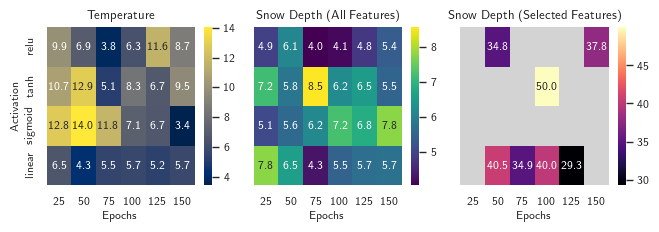

In [132]:
all_mse = [mse_matrix_temp, mse_matrix_snow_all, mse_matrix_snow_selected]
cmaps = ['cividis', 'viridis', 'magma']
titles = ['Temperature', 'Snow Depth (All Features)', 'Snow Depth (Selected Features)']

for i, matrix in enumerate(all_mse):
    matrix[matrix > 50] = np.nan
    all_mse[i] = matrix

fig, axes = plt.subplots(
    1, len(all_mse),
    figsize=(tw, 6/2.54),
    sharey=True
)

if len(mse_results) == 1:
    axes = [axes]

for i, (ax, matrix) in enumerate(zip(axes, all_mse)):
    nan_mask = np.isnan(matrix)
    print(nan_mask)
    sns.heatmap(
        matrix,
        ax=ax,
        xticklabels=epochs_range,
        yticklabels=activations,
        annot=True,
        fmt=".1f",
        cbar=True,
        cmap=cmaps[i],
        mask=nan_mask,
        linecolor='gray'
    )
    ax.set_title(titles[i])
    ax.set_xlabel("Epochs")
    ax.set_facecolor('lightgray')
    ax.grid(False)

axes[0].set_ylabel("Activation")

plt.tight_layout()
saveplot('hm_activations_epochs')

In [87]:
all_mse = np.concatenate([
    v["mse_matrix"].ravel() for v in mse_results.values()
])

vmin, vmax = all_mse.min(), all_mse.max()


In [32]:
def make_bias_initializer(y_train):
    last_vals = y_train[-12:].flatten()
    return Constant(float(np.mean(last_vals)))

In [ ]:
units_range = [16, 32, 64, 128, 256]
optimal_epochs_activation = [(150, 'sigmoid'), 
                             (75, 'relu'), 
                             (125, 'linear')]  # from previous analysis

results = {}

n_features = X_train.shape[2]
bias_initializer = make_bias_initializer(y_train)

for i, (target_col, feature_cols,
        (X_train, y_train),
        (X_test, y_test)) in enumerate(
        zip(target_cols, feature_cols_list, train_sets, test_sets)):

    name = f"{target_col} | {feature_cols}"
    epochs, activation = optimal_epochs_activation[i]

    print(f"\n=== {name} ===")

    bias_initializer = bias_init(y_train)
    n_features = X_train.shape[2]

    mse_no_bias = []
    mse_bias = []

    for units in units_range:
        for use_bias in [False, True]:

            print(f"Units: {units} | Bias: {use_bias}")

            model = Sequential([
                LSTM(
                    units,
                    activation=activation,
                    input_shape=(timesteps, n_features)
                ),
                Dense(
                    horizon,
                    bias_initializer=bias_initializer if use_bias else None
                )
            ])

            model.compile(optimizer='adam', loss='mse')

            model.fit(
                X_train, y_train,
                epochs=epochs,
                batch_size=16,
                verbose=0
            )

            # --- predict on test set ---
            y_pred = model.predict(X_test)

            # --- inverse scaling ---
            y_pred_rescaled = target_scaler.inverse_transform(
                y_pred.reshape(-1, 1)
            ).reshape(y_pred.shape)

            y_test_rescaled = target_scaler.inverse_transform(
                y_test.reshape(-1, 1)
            ).reshape(y_test.shape)

            y_true = y_test_rescaled.flatten()
            y_pred = y_pred_rescaled.flatten()

            mask = np.isfinite(y_true) & np.isfinite(y_pred)

            if np.sum(mask) == 0:
                mse = np.nan
            else:
                mse = mean_squared_error(y_true[mask], y_pred[mask])


            if use_bias:
                mse_bias.append(mse)
            else:
                mse_no_bias.append(mse)

    results[name] = {
        "units": units_range,
        "no_bias": np.array(mse_no_bias),
        "bias": np.array(mse_bias),
    }


=== temperature | ['snowdepth', 'irradiation', 'precipitation', 'rhumidity', 'windspeed', 'temperature'] ===
Units: 16 | Bias: False


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step  
Units: 16 | Bias: True


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step 
Units: 32 | Bias: False


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
Units: 32 | Bias: True


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
Units: 64 | Bias: False


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
Units: 64 | Bias: True


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Units: 128 | Bias: False


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step 
Units: 128 | Bias: True


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step 
Units: 256 | Bias: False


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step 
Units: 256 | Bias: True


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step 

=== snowdepth | ['snowdepth', 'irradiation', 'precipitation', 'rhumidity', 'windspeed', 'temperature'] ===
Units: 16 | Bias: False


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Units: 16 | Bias: True


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
Units: 32 | Bias: False


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step 
Units: 32 | Bias: True


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 
Units: 64 | Bias: False


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 
Units: 64 | Bias: True


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step 
Units: 128 | Bias: False


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step 
Units: 128 | Bias: True


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 
Units: 256 | Bias: False


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step 
Units: 256 | Bias: True


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step 

=== snowdepth | ['temperature', 'windspeed'] ===
Units: 16 | Bias: False


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step 
Units: 16 | Bias: True


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step
Units: 32 | Bias: False


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step 
Units: 32 | Bias: True


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Units: 64 | Bias: False


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
Units: 64 | Bias: True


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step 
Units: 128 | Bias: False


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Units: 128 | Bias: True


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
Units: 256 | Bias: False


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step 
Units: 256 | Bias: True


c:\Users\Dell\anaconda3\envs\tf\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step 


In [33]:
import re

for name, res in results.items():
    safe_name = re.sub(r"[^\w\-]+", "_", name)

    df = pd.DataFrame({
        "units": res["units"],
        "mse_no_bias": res["no_bias"],
        "mse_bias": res["bias"],
    })

    df.to_csv(f"mse_bias_comparison_{safe_name}.csv", index=False)

In [34]:
mses_paths = glob.glob("mse_bias_*.csv")

mses_dfs = []

for path in mses_paths:
    df = pd.read_csv(path)
    name = path.replace("mse_bias_comparison_", "").replace(".csv", "")
    mses_dfs.append((name, df))

mses_dfs

[('snowdepth_snowdepth_irradiation_precipitation_rhumidity_windspeed_temperature_',
     units  mse_no_bias  mse_bias
  0     16     5.877703  5.437790
  1     32     6.003684  7.536541
  2     64     7.285228  6.606706
  3    128     5.594360  4.912334
  4    256    23.061253  5.615615),
 ('snowdepth_temperature_windspeed_',
     units  mse_no_bias   mse_bias
  0     16    69.424792  50.921238
  1     32   296.605104  42.192408
  2     64    21.479849  57.596206
  3    128    26.672466  53.184690
  4    256   176.230382  46.225646),
 ('temperature_snowdepth_irradiation_precipitation_rhumidity_windspeed_temperature_',
     units  mse_no_bias   mse_bias
  0     16    33.306680  45.573721
  1     32    24.652115  30.319895
  2     64    23.331627  22.184188
  3    128    25.474416  18.206343
  4    256    24.395653  25.025189)]

In [35]:
# ChatGPT converted dfs for bar plotting
transformed_dfs = []

for name, df in mses_dfs:
    
    new_rows = []
    for _, row in df.iterrows():
        # no bias row
        new_rows.append({
            'units': int(row['units']),
            'mse': row['mse_no_bias'],
            'bias': False
        })
        # bias row
        new_rows.append({
            'units': int(row['units']),
            'mse': row['mse_bias'],
            'bias': True
        })
    new_df = pd.DataFrame(new_rows)
    transformed_dfs.append((name, new_df))

transformed_dfs

[('snowdepth_snowdepth_irradiation_precipitation_rhumidity_windspeed_temperature_',
     units        mse   bias
  0     16   5.877703  False
  1     16   5.437790   True
  2     32   6.003684  False
  3     32   7.536541   True
  4     64   7.285228  False
  5     64   6.606706   True
  6    128   5.594360  False
  7    128   4.912334   True
  8    256  23.061253  False
  9    256   5.615615   True),
 ('snowdepth_temperature_windspeed_',
     units         mse   bias
  0     16   69.424792  False
  1     16   50.921238   True
  2     32  296.605104  False
  3     32   42.192408   True
  4     64   21.479849  False
  5     64   57.596206   True
  6    128   26.672466  False
  7    128   53.184690   True
  8    256  176.230382  False
  9    256   46.225646   True),
 ('temperature_snowdepth_irradiation_precipitation_rhumidity_windspeed_temperature_',
     units        mse   bias
  0     16  33.306680  False
  1     16  45.573721   True
  2     32  24.652115  False
  3     32  30.319895  

C:\Users\Dell\AppData\Local\Temp\ipykernel_32684\1000664111.py:9: UserWarning: The palette list has more values (12) than needed (2), which may not be intended.
  sns.barplot(ax=ax,
C:\Users\Dell\AppData\Local\Temp\ipykernel_32684\1000664111.py:9: UserWarning: The palette list has more values (12) than needed (2), which may not be intended.
  sns.barplot(ax=ax,
C:\Users\Dell\AppData\Local\Temp\ipykernel_32684\1000664111.py:9: UserWarning: The palette list has more values (12) than needed (2), which may not be intended.
  sns.barplot(ax=ax,


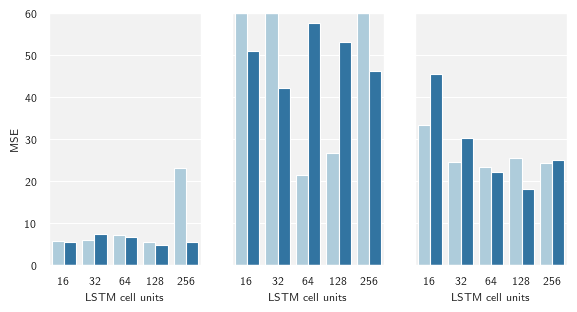

In [42]:
titles = ["Temperature", "Snow Depth (All Features)", "Snow Depth (Selected Features)"]

fig, axes = plt.subplots(1, 3, figsize=(tw, cw), sharey=True)

for i, df in enumerate(transformed_dfs):
    name, data = df
    ax = axes[i]

    sns.barplot(ax=ax,
                x='units', 
                y='mse', 
                data=data,
                hue='bias',
                palette=sns.color_palette('Paired'),  # Use Paired 
                legend=False
                )

    ax.set_ylim(0, 60)
    ax.set_xlabel("LSTM cell units")
    ax.set_ylabel("MSE")

In [43]:
results = {}

# optimal architectures for different targets from previous analyses
uaeb = [
    (128, 'sigmoid', 150, make_bias_initializer(y_train)),
    (64, 'relu', 75, None),
    (128, 'linear', 125, make_bias_initializer(y_train))
]

for (i, target_col), feature_cols, (X_train, y_train), (X_test, y_test) in zip(
        enumerate(target_cols), feature_cols_list, train_sets, test_sets):

    print(f"\nTraining LSTM for target: {target_col}")
    print(f"Features: {feature_cols}")

    n_features = X_train.shape[2]

    units, activation, epochs, bias = uaeb[i]

    model = Sequential([
        LSTM(units,
             activation=activation, 
             input_shape=(history_rows, n_features)),
        Dense(horizon,
              bias_initializer=bias)
    ])

    model.compile(
        optimizer='adam',
        loss='mse'
    )

    model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=8,
        verbose=1
    )

    # --- last input window ---
    last_window = pont_df[feature_cols].iloc[-history_rows:].values
    last_window = last_window.reshape(1, history_rows, n_features)

    # --- forecast ---
    forecast_scaled = model.predict(last_window)

    # --- inverse scaling ---
    y_train_raw = df_clean[target_col].loc[:split_time].values
    target_scaler = StandardScaler()
    target_scaler.fit(y_train_raw.reshape(-1, 1))

    forecast_rescaled = target_scaler.inverse_transform(forecast_scaled)
    true_rescaled = target_scaler.inverse_transform(
        y_test[0].reshape(-1, 1)
    ).flatten()

    forecast_rescaled = forecast_rescaled.flatten()

    # --- metrics ---
    mse = mean_squared_error(true_rescaled, forecast_rescaled)
    r2 = r2_score(true_rescaled, forecast_rescaled)

    print(f"MSE = {mse:.4f}")
    print(f"R²  = {r2:.4f}")

    # --- store results ---
    results[target_col, tuple(feature_cols)] = {
        "forecast": forecast_rescaled,
        "true": true_rescaled,
        "mse": mse,
        "r2": r2
    }




Training LSTM for target: temperature
Features: ['snowdepth', 'irradiation', 'precipitation', 'rhumidity', 'windspeed', 'temperature']


c:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 4s 13ms/step - loss: 1.0726
Epoch 2/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6808
Epoch 3/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4468
Epoch 4/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.4040
Epoch 5/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 26ms/step - loss: 0.3648
Epoch 6/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 33ms/step - loss: 0.3404
Epoch 7/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.3177
Epoch 8/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.2975
Epoch 9/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.3010
Epoch 10/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.2644
Epoch 11/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.2444
Epoch 12/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - loss: 0.2359
Epoch 13/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.2276
Epoch 14/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 34ms/step - loss: 0.2114
Epoch 15/150
82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 35ms/step - lo

c:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 7s 28ms/step - loss: 0.7660
Epoch 2/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.4752
Epoch 3/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.3039
Epoch 4/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - loss: 0.1740
Epoch 5/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0864
Epoch 6/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0607
Epoch 7/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0485
Epoch 8/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0389
Epoch 9/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0319
Epoch 10/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0284
Epoch 11/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0234
Epoch 12/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.0209
Epoch 13/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0202
Epoch 14/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0177
Epoch 15/75
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.0154
Epoc

c:\Users\Dell\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


82/82 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 133.3252
Epoch 2/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 2.5056
Epoch 3/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 2.2823
Epoch 4/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 2.0785
Epoch 5/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.8839
Epoch 6/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.7038
Epoch 7/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.5357
Epoch 8/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.3802
Epoch 9/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 1.2390
Epoch 10/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 1.1110
Epoch 11/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.9988
Epoch 12/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.9016
Epoch 13/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - loss: 0.8140
Epoch 14/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.7457
Epoch 15/125
82/82 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step - loss: 0.6867

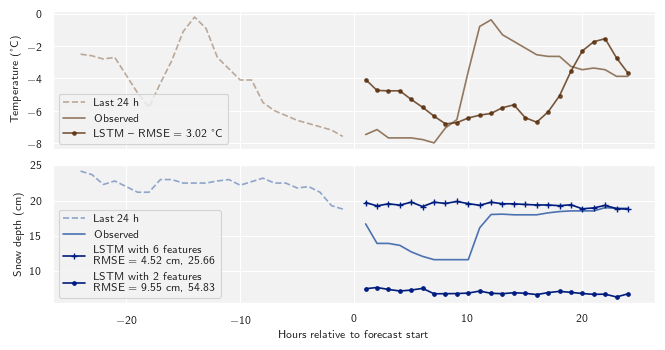

In [53]:
fig, axes = plt.subplots(2, 1, figsize=(tw, 9/2.54), sharex=True)

# time axes
t_context = np.arange(-24, 0)
t_forecast = np.arange(1, horizon + 1)

snow_color = sns.color_palette(n_colors=6)[0]
temp_color = sns.color_palette(n_colors=6)[5]

snow_forecast_color = sns.color_palette('dark', n_colors=6)[0]
temp_forecast_color = sns.color_palette('dark', n_colors=6)[5]

# =========================
# temperature
# =========================
key_temp = [k for k in results if k[0] == "temperature"][0]

# last 24 h before forecast

true_temp = results[key_temp]["true"]
forecast_temp = results[key_temp]["forecast"]

rmse_temp = np.sqrt(mean_squared_error(true_temp, forecast_temp))

temp_context = df_clean["temperature"].loc[:split_time].values[-24:]

axes[0].plot(t_context, temp_context, 
                c=temp_color,  label="Last 24 h",
                alpha=0.6, linestyle='dashed')
axes[0].plot(t_forecast, true_temp, label="Observed",
             color=temp_color)
axes[0].plot(t_forecast, forecast_temp, marker=".", label=f"LSTM -- RMSE = {rmse_temp:.2f} °C",
             color=temp_forecast_color, alpha=0.8)

axes[0].set_ylabel("Temperature (°C)")
axes[0].legend(loc='lower left')

# =========================
# snow depth
# =========================
snow_keys = [k for k in results if k[0] == "snowdepth"]

snow_context = df_clean["snowdepth"].loc[:split_time].values[-24:]

mses_snow = [26.4, 67.5]

axes[1].plot(t_context, snow_context, linestyle='dashed', alpha=0.6, color=snow_color, label="Last 24 h")
markers = ['+', '.']

axes[1].plot(
    t_forecast,
    results[snow_keys[0]]["true"],
    color=snow_color,
    label="Observed"
)

for i, key in enumerate(snow_keys):
    snow_true = results[key]["true"]
    snow_forecast_i = results[key]["forecast"]

    rmse_snow_i = np.sqrt(mean_squared_error(snow_true, snow_forecast_i))
    ratio_tot_i = np.mean(np.abs(snow_true - snow_forecast_i) / snow_true) * 100

    label = f"LSTM with {len(key[1])} features\nRMSE = {rmse_snow_i:.2f} cm, {ratio_tot_i:.2f}% of average total thickness"
    axes[1].plot(
        t_forecast,
        snow_forecast_i,
        marker=markers[i],
        color=snow_forecast_color,
        label=label
    )

axes[1].set_xlabel("Hours relative to forecast start")
axes[1].set_ylabel("Snow depth (cm)")
axes[1].legend(loc='lower left')

plt.tight_layout()
saveplot('forecasts')